# Channel Map File Creation

In [79]:
import numpy as np

# See the channel maps for Wifi and Router to undesrtand the 
# patterns described in this code to create the channel map (specifically for xc and yc).
# Also look https://microprobes.com/products/multichannel-arrays/fma to see
# the physical layout of the FMA and the numbers chosen.

# The spacing between different shanks 
# has they are physically implanted in the cortex
shank_h_gap = 4000 # micron
shank_v_gap = 2000 # micron


num_channels = 128
xc_center = 12.5
yc_center = 12.5

# The numbering goes 4 by 4 as the channels are sequentially diustributed in 4 implants at a time.
# Create the base pattern for the first 32 elements
base_pattern = np.arange(0, 128, 4)
# Create the full array by repeating and incrementing the base pattern
chanMap = np.concatenate([base_pattern + i for i in range(4)])


# Pattern for the x coordinates
x_step = 400 # micron
# This is to discard the 4 electrode positions of 36 that are not recording channels, see map image.
base_patternB = np.flip(np.arange(xc_center + x_step, x_step * 9, x_step))
base_patternA = np.flip(np.arange(xc_center, x_step * 8, x_step))
xc = np.concatenate([ base_patternA if i%2==0 else base_patternB for i in range(4)])
xc = np.concatenate([xc for _ in range(4)])

# Pattern for y coordinates
y_step = 346.4 # micron
base_pattern = np.array([xc_center] * 8)
yc = np.concatenate([base_pattern + y_step * i for i in range(4)])
yc = np.concatenate([yc for i in range(4)])


# This definiton introduces 8 fictious groups, to implement the shaggering of the FMA, so electrodes are
# oprganized as pairs of different lengths. with distance that are well represented with different shanks,
# even though they are not physically separated.
# Define the base pattern for the first 32 elements
# base_pattern = np.array([1, 1, 2, 2] * 8)
# Create the full array by repeating and incrementing the base pattern
# k_coords = np.concatenate([base_pattern + 2 * i for i in range(4)])

# Use standard definiton for k_coord: 4 shanks, 4 values for k_coord from 1 to 4
# it ignores the shaggering of the FMA
base_pattern = np.array([1] * 32)
k_coords = np.concatenate([base_pattern + i for i in range(4)])

# Shift the shanks in "real space" as they are placed on the cortex
#  [ D ]  [ C ]
#  [ B ]  [ A ]
# This is the order of the shanks in the cortex, where [A, B, C, D] = [1, 2, 3, 4]
xc[k_coords == 2] -= shank_h_gap
xc[k_coords == 4] -= shank_h_gap
yc[k_coords == 3] += shank_v_gap
yc[k_coords == 4] += shank_v_gap

# Flip over x and y shanks C and D (see the physical representation)
xc[k_coords == 3] = np.flip(xc[k_coords == 3])
xc[k_coords == 4] = np.flip(xc[k_coords == 4])
yc[k_coords == 3] = np.flip(yc[k_coords == 3])
yc[k_coords == 4] = np.flip(yc[k_coords == 4])

# Check that all arrays have the same length
assert len(chanMap) == len(xc) == len(yc) == len(k_coords) == num_channels == num_channels

probe = {
    'chanMap': chanMap,
    'xc': xc,
    'yc': yc,
    'kcoords': k_coords,
    'n_chan': num_channels
}

# print(probe)

# Run this on kilosort env to save the probe file
# from kilosort.io import save_probe

# save_probe(probe, './wireless_channel_map_kilosort.json')


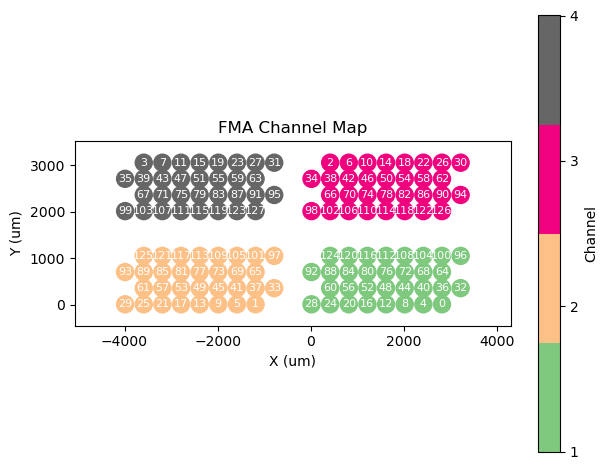

In [80]:
# Plot the map
import matplotlib.pyplot as plt

# Get unique values in k_coords
unique_k = np.sort(np.unique(k_coords))
num_unique = len(unique_k)

scatter = plt.scatter(xc, yc, c=k_coords, s=150,
            cmap=plt.get_cmap('Accent', num_unique))
plt.xlabel('X (um)')
plt.ylabel('Y (um)')
plt.title('FMA Channel Map')

# Set up colorbar with integer ticks
cbar = plt.colorbar(scatter, ticks=unique_k)
cbar.set_label('Channel')

# Add text labels with channel numbers
for i in range(len(chanMap)):
    plt.text(xc[i], yc[i], str(int(chanMap[i])), 
             ha='center', va='center', fontsize=8, color='white')

# Add 10% margin to axes
x_min, x_max = np.min(xc), np.max(xc)
y_min, y_max = np.min(yc), np.max(yc)
x_margin = (x_max - x_min) * 0.15
y_margin = (y_max - y_min) * 0.15
plt.xlim(x_min - x_margin, x_max + x_margin)
plt.ylim(y_min - y_margin, y_max + y_margin)

# Set equal aspect ratio
plt.gca().set_aspect('equal','box')
plt.tight_layout()

plt.show()